In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import skimage.io as skio
import openslide
import pandas as pd
from glom import glom
import PIL
import numpy

import matplotlib
import matplotlib.pyplot as plt


In [2]:
#Defining Functions

#extract_patches and plot_patches source code: https://gist.github.com/dwf/366247/6b8497243a5dd53ac5fbdace0acd7d0cfbdf5ca6
def extract_patches(image, patchshape, overlap_allowed=0.5, cropvalue=None,
                    crop_fraction_allowed=0.1):

    jump_cols = int(patchshape[1] * overlap_allowed)
    jump_rows = int(patchshape[0] * overlap_allowed)
    
    # Restrict to the rectangle containing non-cropped pixels
    if cropvalue is not None:
        rows, cols = np.where(image != cropvalue)
        rows.sort(); cols.sort()
        active =  image[rows[0]:rows[-1], cols[0]:cols[-1]]
    else:
        active = image

    rowstart = 0; colstart = 0

    # Array tracking - Check if the patches were already extracted.
    covered = np.zeros(active.shape, dtype=bool)
    patches = []

    while rowstart < active.shape[0] - patchshape[0]:
        # Record whether or not we've found a patch in this row, 
        # to know whether to skip ahead.
        got_a_patch_this_row = False
        colstart = 0
        while colstart < active.shape[1] - patchshape[1]:
            # Slice tuple indexing the region of our proposed patch
            region = (slice(rowstart, rowstart + patchshape[0]),
                      slice(colstart, colstart + patchshape[1]))
            
            # The actual pixels in that region.
            patch = active[region]

            # The current mask value for that region.
            cover_p = covered[region]
            if cropvalue is None or \
               frac_eq_to(patch, cropvalue) <= crop_fraction_allowed and \
               frac_eq_to(cover_p, True) <= overlap_allowed:
                # Accept the patch.
                patches.append(patch)
                
                # Mask the area.
                covered[region] = True
                
                # Jump ahead in the x direction.
                colstart += jump_cols
                got_a_patch_this_row = True
                #print "Got a patch at %d, %d" % (rowstart, colstart)
            else:
                # Otherwise, shift window across by one pixel.
                colstart += 1

        if got_a_patch_this_row:
            # Jump ahead in the y direction.
            rowstart += jump_rows
        else:
            # Otherwise, shift the window down by one pixel.
            rowstart += 1

    # Return a 3D array of the patches with the patch index as the first
    # dimension
    return np.concatenate([pat[np.newaxis, ...] for pat in patches], axis=0)

def plot_patches(patches, fignum=None, low=0, high=0):
    try:
        istate = plt.isinteractive()
        plt.ioff()
        if fignum is None:
            fig = plt.gcf()
        else:
            fig = plt.figure(fignum)
        if high == 0:
            high = len(patches)
        pmin, pmax = patches.min(), patches.max()
        dims = np.ceil(np.sqrt(high - low))
        for idx in range(high - low):
            spl = plt.subplot(dims, dims, idx + 1)
            ax = plt.axis('off')
            im = plt.imshow(patches[idx], cmap=matplotlib.cm.gray)
            cl = plt.clim(pmin, pmax)
        plt.show()
    finally:
        plt.interactive(istate)
        
def Remove(duplicate):
    final_list = []
    for num in duplicate:
        if num not in final_list:
            final_list.append(num)
    return final_list

def flatList(listoflist):
    return [item for elem in listoflist for item in elem]


1259303.svs
stored slide size pyramid ((68400, 30719), (17100, 7679), (4275, 1919), (2137, 959))
fetched shape (7679, 17100, 4)


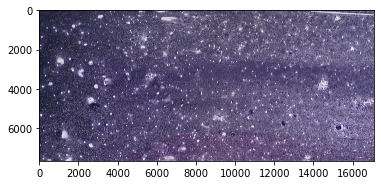

In [10]:
# Read slides in .svs from dir 
# Read WSI files source code: https://github.com/xiangli980/WSI-Segmentation-Pipeline/blob/master/WSI_Preprocess/step1_read_WSI.ipynb
slidelist = os.listdir("./slides")

#CHANGE THIS ACCORDINGLY --------------------------------------------------------------------
level = 1 #MAsgnification level
#CHANGE THIS ACCORDINGLY --------------------------------------------------------------------

for slidei in slidelist[:]:
    print(slidei)
    idi = slidei.split('_')[0]
    ORGFilename = idi.split('.')[0]
    
    # open slide.svs
    slide_0 = openslide.OpenSlide('./slides/{}'.format(slidei))
    levels = slide_0.level_dimensions
    print("stored slide size pyramid",levels)

    # fetch levels[level] size of whole WSI region
    slide = slide_0.read_region((0,0),level,levels[level])
    slide = np.asarray(slide)
    print("fetched shape",slide.shape)

    # origin slide is in RGBA format, convert it to RGB and save to model data dir
    slide = cv2.cvtColor(slide, cv2.COLOR_RGBA2RGB)
    skio.imsave('./WSI/slide_{}.png'.format(ORGFilename),slide.astype("uint8"))
    plt.imshow(slide)
    plt.show()

In [11]:
dims = levels[level]
Ximageorg, Yimageorg = levels[0]

In [12]:
#Convert json data to df with columns: Annotation, X,Y Cooordinates and Order 
# for easier processing of annotation values


#CHANGE THIS ACCORDINGLY --------------------------------------------------------------------
AnnotFile = '1259303.json' # This JSON data is exported from QuPath
#CHANGE THIS ACCORDINGLY --------------------------------------------------------------------

file_dir = 'annot\\'+AnnotFile 

annotations = pd.read_json(file_dir)

AllClasses = annotations['properties'].apply(lambda row: glom(row, 'classification.name'))

AllColors = annotations['properties'].apply(lambda row: glom(row, 'classification.colorRGB'))

AllCoord = annotations['geometry'].apply(lambda row: glom(row, 'coordinates'))




In [14]:
#Scale coordinates based on the level selected -> May take a while to complete execution 
# depends on the number of annotations present in the JSON file.

dfcols = ['Order', 'X', 'Y', 'Name', 'Color','X_Org','Y_Org']
df_json = pd.DataFrame(columns=dfcols)


for i in range(len(AllCoord)):
    OrginalList = AllCoord[i]
    Color = AllColors[i]
    Name = AllClasses[i]
    while len(OrginalList) <= 10:
        OrginalList = flatList(OrginalList)
    for j in range(len(OrginalList)):
        X_coord = OrginalList[j][0]
        X_coord_org = X_coord
        X_coord = ((X_coord)*dims[0])/Ximageorg
        Y_coord = OrginalList[j][1]
        Y_coord_org = Y_coord
        Y_coord = ((Y_coord)*dims[1])/Yimageorg
        #Use below line for Viewing
        df_json = df_json.append(pd.Series([j, X_coord, Y_coord, Name+'_'+str(i), Color, X_coord_org, Y_coord_org], index = dfcols), ignore_index=True)
    df_json = pd.DataFrame(df_json) 
        

In [15]:
#View the content of the annotation file
df_json.head()

,Order,X,Y,Name,Color,X_Org,Y_Org
0,0,13557.75,3808.628015,Squamous cell carcinoma_0,-12840029,54231,15236
1,1,13558.75,3809.127966,Squamous cell carcinoma_0,-12840029,54235,15238
2,2,13558.50,3808.877991,Squamous cell carcinoma_0,-12840029,54234,15237
3,3,13558.50,3808.753003,Squamous cell carcinoma_0,-12840029,54234,15236.5
4,4,13558.00,3808.628015,Squamous cell carcinoma_0,-12840029,54232,15236


In [16]:
#Remove duplcate values if any
final_list = Remove(df_json['Name'])

coxy = [[] for x in range(len(final_list))]

In [17]:
#Preparing coordinates to be applied over an empty mask file
i = 0
for n in final_list:
    newx = df_json[df_json['Name']== n]['X']
    newy = df_json[df_json['Name']== n]['Y']
    #print(n)
    #print(newx, newy)
    newxy = list(zip(newx, newy))
    coxy[i] = np.array(newxy, dtype=np.int32)
    i=i+1

In [18]:
img = np.zeros((dims[1],dims[0], 3), np.uint8)

for i in range(len(coxy)):
    cv2.fillConvexPoly(img, coxy[i], (255, 255, 255))
    


In [21]:
#CHANGE THIS ACCORDINGLY --------------------------------------------------------------------
MaskPNG_Loc = "FullImageMasks\\" #Location where the code saves a png version of the WSI
WSIPNG_Loc = "WSI\\" #Location where the code saves a png version of the Mask file
#CHANGE THIS ACCORDINGLY ---------------------------------------------------------------------

maskfilename = ORGFilename+"_Annot_level"+str(level)+".png"

cv2.imwrite(MaskPNG_Loc+maskfilename, img)

True

In [22]:
# use below code incase of loading huge image files
"""
Image.MAX_IMAGE_PIXELS = None
mat = Image.open("FilledConturImg.png")
img = np.array(mat)
print(img.shape)
"""


'\nImage.MAX_IMAGE_PIXELS = None\nmat = Image.open("FilledConturImg.png")\nimg = np.array(mat)\nprint(img.shape)\n'

In [26]:
# Extract Patches using the earlier saved png files

img = PIL.Image.open(MaskPNG_Loc+maskfilename).convert("L")
arr = numpy.array(img)

window_shape = (256, 256)


Mask_Patches = extract_patches(arr, window_shape, overlap_allowed=0.5, cropvalue=None,
                    crop_fraction_allowed=0.1)

filename = "slide_"+ORGFilename+".png"

img = PIL.Image.open(WSIPNG_Loc+filename).convert("L")
arr = numpy.array(img)

WSI_Patches = extract_patches(arr, window_shape, overlap_allowed=0.5, cropvalue=None,
                    crop_fraction_allowed=0.1)

print("Total Patches: "+str(len(WSI_Patches)))



c:\users\aa647\appdata\local\programs\python\python36\lib\site-packages\PIL\Image.py:2835: DecompressionBombWarning: Image size (131310900 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Total Patches: 7656


In [27]:
#CHANGE THIS ACCORDINGLY ----------------------------------------------------------
MaskPatches_Loc = "masks\\" #Location where all extracted mask patches are saved
WSIPathes_Loc = "patches\\" #Location where all WSI patches are saved
#CHANGE THIS ACCORDINGLY ----------------------------------------------------------

In [28]:
#Extract Patches from Mask PNG file
for i in range(len(Mask_Patches)):
    cv2.imwrite(MaskPatches_Loc+"patch_"+str(i)+".png", Mask_Patches[i])

In [29]:
#Extract patches from WSI PNG file
for i in range(len(WSI_Patches)):
    cv2.imwrite(WSIPathes_Loc+"patch_"+str(i)+".png", WSI_Patches[i])

In [ ]:
#look at WSI patches
plot_patches(WSI_Patches, low=10, high = 22)

In [ ]:
#look at maks patches
plot_patches(Mask_Patches, low=10, high = 22)